In [1]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [3]:
#Get data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from underthesea import word_tokenize, sent_tokenize, pos_tag
import regex
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Feature Engineering
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils
from gensim.models import KeyedVectors

#Over-sampling
from imblearn.over_sampling import SMOTE

#Phobert
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


#Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Get data

In [4]:
def get_data(data_path_sents, data_path_sentiments):
    with open(data_path_sents, 'r', encoding='utf-8') as file:
        sents = file.readlines()
    with open(data_path_sentiments, 'r', encoding='utf-8') as file:
        sentiments = file.readlines()
    return pd.DataFrame({'sentences':sents, 'sentiments':sentiments})

In [6]:
train_data = get_data('/content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/train-20241208T060932Z-001/sents.txt', '/content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/train-20241208T060932Z-001/sentiments.txt')
validation_data = get_data('/content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/dev-20241208T060957Z-001/sents.txt', '/content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/dev-20241208T060957Z-001/sentiments.txt')
test_data = get_data('/content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/test-20241208T060919Z-001/sents.txt', '/content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/test-20241208T060919Z-001/sentiments.txt')

# Preprocessing

## Preprocessing sentiments

In [7]:
#Preprocessing sentiment
def process_sentiment(text):
    text = text.replace('\n', '')
    return text

In [8]:
train_data['sentiments'] = train_data['sentiments'].apply(lambda x: process_sentiment(str(x)))
train_data['sentiments'] = train_data['sentiments'].astype(int)
validation_data['sentiments'] = validation_data['sentiments'].apply(lambda x: process_sentiment(str(x)))
validation_data['sentiments'] = validation_data['sentiments'].astype(int)
test_data['sentiments'] = test_data['sentiments'].apply(lambda x: process_sentiment(str(x)))
test_data['sentiments'] = test_data['sentiments'].astype(int)

## Preprocessing sentences

In [9]:
#Load Teencode
file = open('/content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/file_preprocess/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
file.close()

In [10]:
def process_text(text, dict_teen):
    document = text.lower() #change to lowercase
    document = document.replace("’",'') #get rid of '
    document = regex.sub(r'\.+', ".", document) #replace ... to .
    new_sentence =''
    for sentence in sent_tokenize(document):
        ###### CONVERT TEENCODE
        sentence = ' '.join(dict_teen[word] if word in dict_teen else word for word in sentence.split())

        ###### DEL Punctuation & Numbers
        pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
        sentence = ' '.join(regex.findall(pattern,sentence))

        new_sentence = new_sentence + sentence
    document = new_sentence

     ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [11]:
train_data['sentences'] = train_data['sentences'].apply(lambda x: process_text(str(x), teen_dict)) #pass each line to process_text
validation_data['sentences'] = validation_data['sentences'].apply(lambda x: process_text(str(x), teen_dict))
test_data['sentences'] = test_data['sentences'].apply(lambda x: process_text(str(x), teen_dict))

In [12]:
def drop_empty_rows(df, column_name):
    df_cleaned = df[df[column_name] != ""]
    return df_cleaned

In [13]:
train_data = drop_empty_rows(train_data, 'sentences')
validation_data = drop_empty_rows(validation_data, 'sentences')
test_data = drop_empty_rows(test_data, 'sentences')

# Split dataset

In [14]:
x_train = train_data['sentences']
x_validation = validation_data['sentences']
x_test = test_data['sentences']

y_train = train_data['sentiments']
y_validation = validation_data['sentiments']
y_test = test_data['sentiments']

# Phobert

In [15]:
from transformers import AutoTokenizer, AutoModel
import torch
import tensorflow as tf

# Tải tokenizer và mô hình PhoBERT
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)
phobert_model = AutoModel.from_pretrained("vinai/phobert-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [16]:
def extract_phobert_embeddings(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Tokenize batch
        tokens = tokenizer(batch_texts, padding=True, truncation=True, max_length=256, return_tensors="pt")

        # Trích xuất embedding cho batch
        with torch.no_grad():
            outputs = phobert_model(**tokens)
            batch_embeddings = outputs.pooler_output.cpu().numpy()  # Chuyển về NumPy để giảm tải GPU

        all_embeddings.extend(batch_embeddings)
    return np.array(all_embeddings)

In [17]:
x_train_embeddings = extract_phobert_embeddings(x_train.tolist(), batch_size=32)

In [18]:
x_validation_embeddings = extract_phobert_embeddings(x_validation.tolist())

In [19]:
x_test_embeddings = extract_phobert_embeddings(x_test.tolist())

In [20]:
def build_classifier_model_phobert():
    input_shape = (768,)  # Kích thước embedding của PhoBERT base là 768
    phobert_input = tf.keras.layers.Input(shape=input_shape, name="phobert_embedding")
    net = tf.keras.layers.Dense(400, activation='relu')(phobert_input)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(200, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(100, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(50, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)
    return tf.keras.Model(inputs=phobert_input, outputs=net)
model = build_classifier_model_phobert()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Callback: Lưu mô hình tốt nhất
callback_model = ModelCheckpoint(
    filepath='/content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/model_save/best_model_phobert.keras',  # Tên file lưu mô hình tốt nhất
    monitor='val_loss',
    save_best_only=True, # Chỉ lưu mô hình tốt nhất
    save_weights_only=False, # Lưu toàn bộ mô hình
    verbose=1
)
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3, # Số epoch chờ trước khi dừng
    restore_best_weights=True, # Khôi phục trọng số tốt nhất
    verbose=1
)
# Huấn luyện mô hình
history = model.fit(
    x_train_embeddings, y_train,
    validation_data=(x_validation_embeddings, y_validation),
    epochs=20,
    batch_size=32,
    callbacks=[callback_model, early_stopping_callback]
)

Epoch 1/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7847 - loss: 0.5154
Epoch 1: val_loss improved from inf to 0.40955, saving model to /content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/model_save/best_model_phobert.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7848 - loss: 0.5152 - val_accuracy: 0.8515 - val_loss: 0.4095
Epoch 2/20
350/358 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8764 - loss: 0.3459
Epoch 2: val_loss improved from 0.40955 to 0.35475, saving model to /content/drive/Othercomputers/My Laptop/MachineLearning/VNmese_student_feedbacks_sentiment/model_save/best_model_phobert.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8765 - loss: 0.3457 - val_accuracy: 0.8743 - val_loss: 0.3548
Epoch 3/20
354/358 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8964 - loss: 0.2920
Epoch 3: val_loss improved from 0.35475 to 0.33049, saving model to /content/drive/Othercomputers/My Laptop/MachineLear

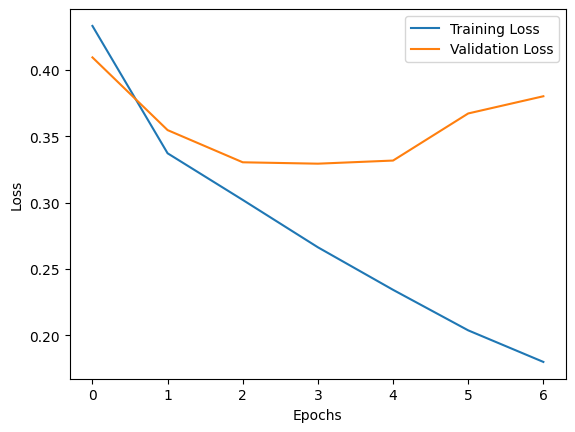

In [22]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
train_loss, train_accuracy = model.evaluate(x_train_embeddings, y_train, verbose=0)
val_loss, val_accuracy = model.evaluate(x_validation_embeddings, y_validation, verbose=0)

print(f"Train Set Error: {train_loss* 100:.2f}%")
print(f"Validation Set Error: {val_loss* 100:.2f}%")

Train Set Error: 20.40%
Validation Set Error: 32.95%


## Evaluation

In [24]:
y_pred_proba = model.predict(x_test_embeddings)
y_pred = np.argmax(y_pred_proba, axis=1)
y_pred

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


array([2, 2, 2, ..., 2, 0, 0])

In [25]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy_train: {accuracy_score(y_train, np.argmax(model.predict(x_train_embeddings), axis=1))}')
print(f'Accuracy_test: {accuracy:.4f}')
precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.4f}')
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Recall: {recall:.4f}')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1-score: {f1:.4f}')
# In ra báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, y_pred))

358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy_train: 0.9312095221424821
Accuracy_test: 0.8692
Precision: 0.8575
Recall: 0.8692
F1-score: 0.8606
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1409
           1       0.46      0.21      0.29       167
           2       0.89      0.90      0.90      1590

    accuracy                           0.87      3166
   macro avg       0.74      0.67      0.69      3166
weighted avg       0.86      0.87      0.86      3166



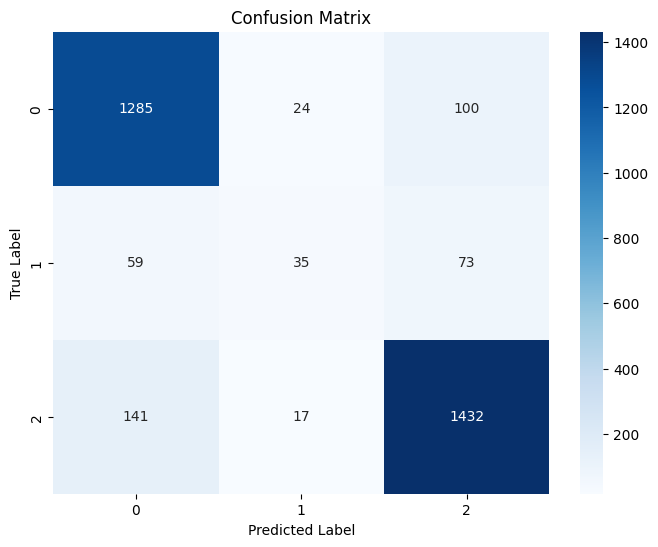

      0   1     2
0  1285  24   100
1    59  35    73
2   141  17  1432


In [26]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
print(pd.DataFrame(cm))